In [1]:
import torch
import torch.nn as nn
import zuko

from lampe.plots import corner
from torch import Tensor
from typing import *
from zuko.utils import broadcast

from priors.nn import MLP
from priors.score import *

## Data

In [2]:
domain = -3.0 * torch.ones(10), 3.0 * torch.ones(10)

def generate(n: int) -> Tensor:    
    return torch.sort(torch.randn(n, 10), dim=-1).values

x = generate(16384).cuda()
A = torch.rand_like(x) < 0.25
y = torch.normal(A * x, 1e-2)

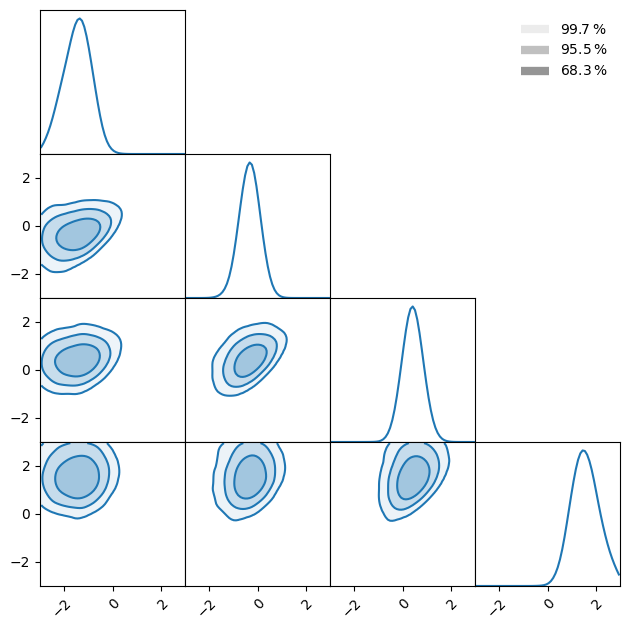

In [3]:
fig = corner(x[..., ::3].cpu(), domain=domain, smooth=2)

100%|██████████| 256/256 [00:00<00:00, 395.97it/s]


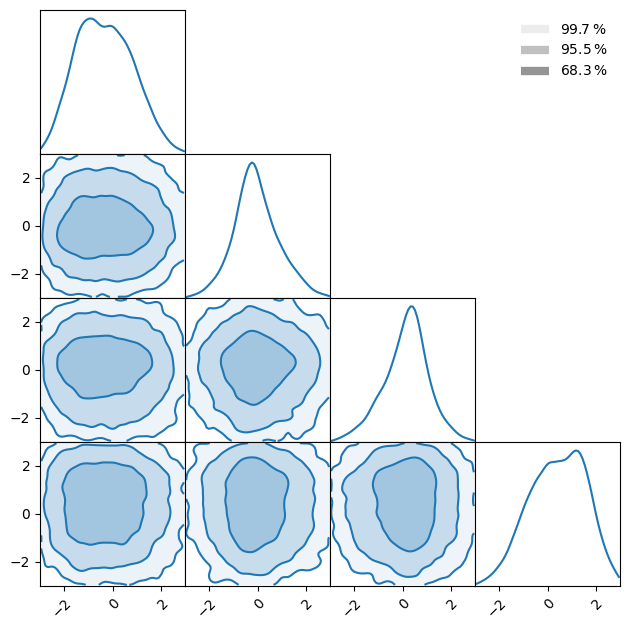

In [4]:
def sample(model, A, y):
    sde = ReverseSDE(
        PosteriorScoreModel(
            model=model,
            y=y,
            A=lambda x: A * x,
            noise=1e-2,
            gamma=1.0,
        )
    ).cuda()

    z = torch.randn_like(y)
    x_bis = sde(z, steps=256, corrections=1, tau=0.25)

    return x_bis

x_bis = sample(StandardScoreModel(), A, y)
fig = corner(x_bis[..., ::3].cpu(), domain=domain, smooth=2)

## Training

In [5]:
class ScoreModel(nn.Module):
    def __init__(self, features: int, **kwargs):
        super().__init__()

        self.embedding = TimeEmbedding(16)
        self.net = MLP(features + 16, features, **kwargs)

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        t = self.embedding(t)
        x = torch.cat(broadcast(x, t, ignore=1), dim=-1)

        return self.net(x)

In [6]:
def train(x, A, y):
    sde = VPSDE()
    model = ScoreModel(10, hidden_features=[256, 256], normalize=True).cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, 8192)

    for step in range(8192):
        i = torch.randint(0, len(x), (256,)).cuda()
        xi = x[i]
        Ai = A[i]

        t = torch.rand_like(xi[..., 0])
        xi, z = sde(xi, t)

        loss = (Ai * model(xi, t) - Ai * z).square().mean()
        loss.backward()

        if step % 1024 == 0:
            print(f'({step})', loss.item())

        optimizer.step()
        optimizer.zero_grad()
        
        scheduler.step()

    return model

(0) 0.3204399347305298
(1024) 0.0632019191980362
(2048) 0.05207725986838341
(3072) 0.0654584988951683
(4096) 0.05666092038154602
(5120) 0.05336190015077591
(6144) 0.05297612026333809
(7168) 0.050400640815496445


100%|██████████| 256/256 [00:02<00:00, 107.36it/s]


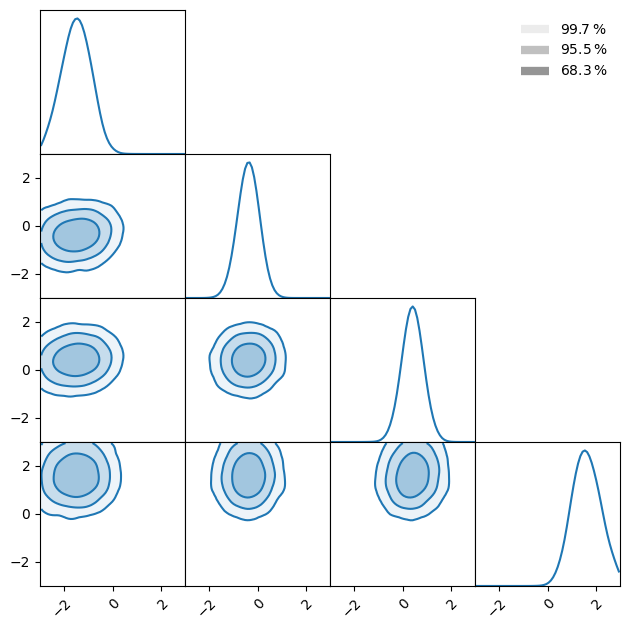

In [7]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = corner(x_bis[..., ::3].cpu(), domain=domain, smooth=2)

(0) 0.3568812906742096
(1024) 0.05881756171584129
(2048) 0.05396125838160515
(3072) 0.06319539248943329
(4096) 0.04845982789993286
(5120) 0.046513449400663376
(6144) 0.050331778824329376
(7168) 0.05097297579050064


100%|██████████| 256/256 [00:02<00:00, 110.17it/s]


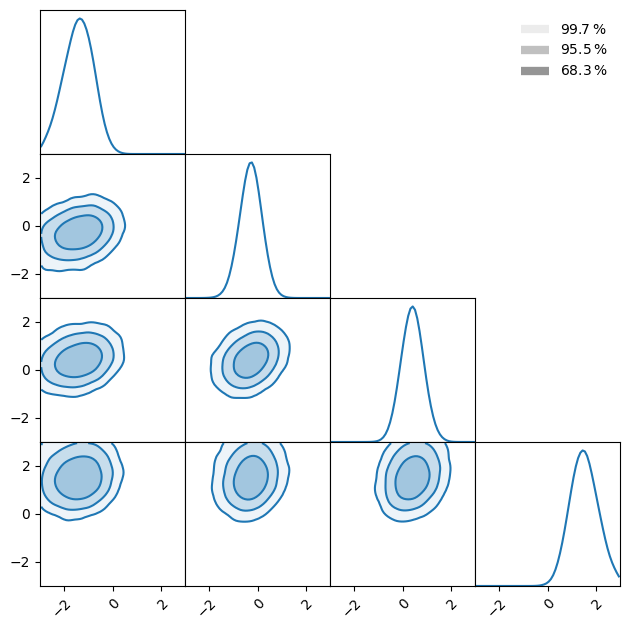

In [8]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = corner(x_bis[..., ::3].cpu(), domain=domain, smooth=2)

100%|██████████| 256/256 [00:00<00:00, 376.42it/s]


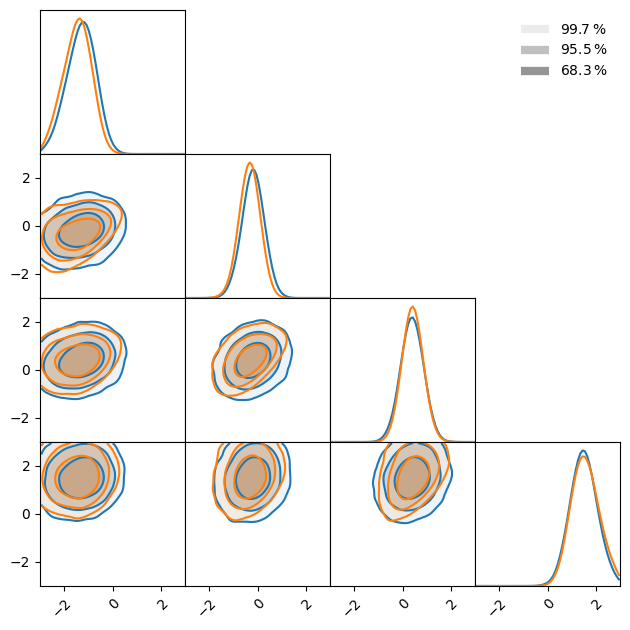

In [9]:
sde = ReverseSDE(model)

z = torch.randn_like(x)
x_ter = sde(z, steps=256, corrections=1, tau=0.25)

fig = corner(x_ter[..., ::3].cpu(), domain=domain, smooth=2)
fig = corner(x[..., ::3].cpu(), domain=domain, smooth=2, figure=fig)